In [69]:
import xml.etree.cElementTree as et
import pandas as pd
import numpy as np
import requests

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.debugger import set_trace
#from statsmodels.stats.proportion import proportion_ztest

# Step 1: Acquire Data From CSV File

In [71]:
beach_complete = pd.read_csv('beach_complete.csv',delimiter=',',header=0,index_col=0)

In [75]:
beach_complete.head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0
2009-06-09,NaN,37.0,368.0,63.0,11.0,20.0,16.0,11.0,12.0,18.0,34.0


In [77]:
beach_clean = beach_complete.dropna()

In [78]:
beach_clean.apply(pd.to_numeric);

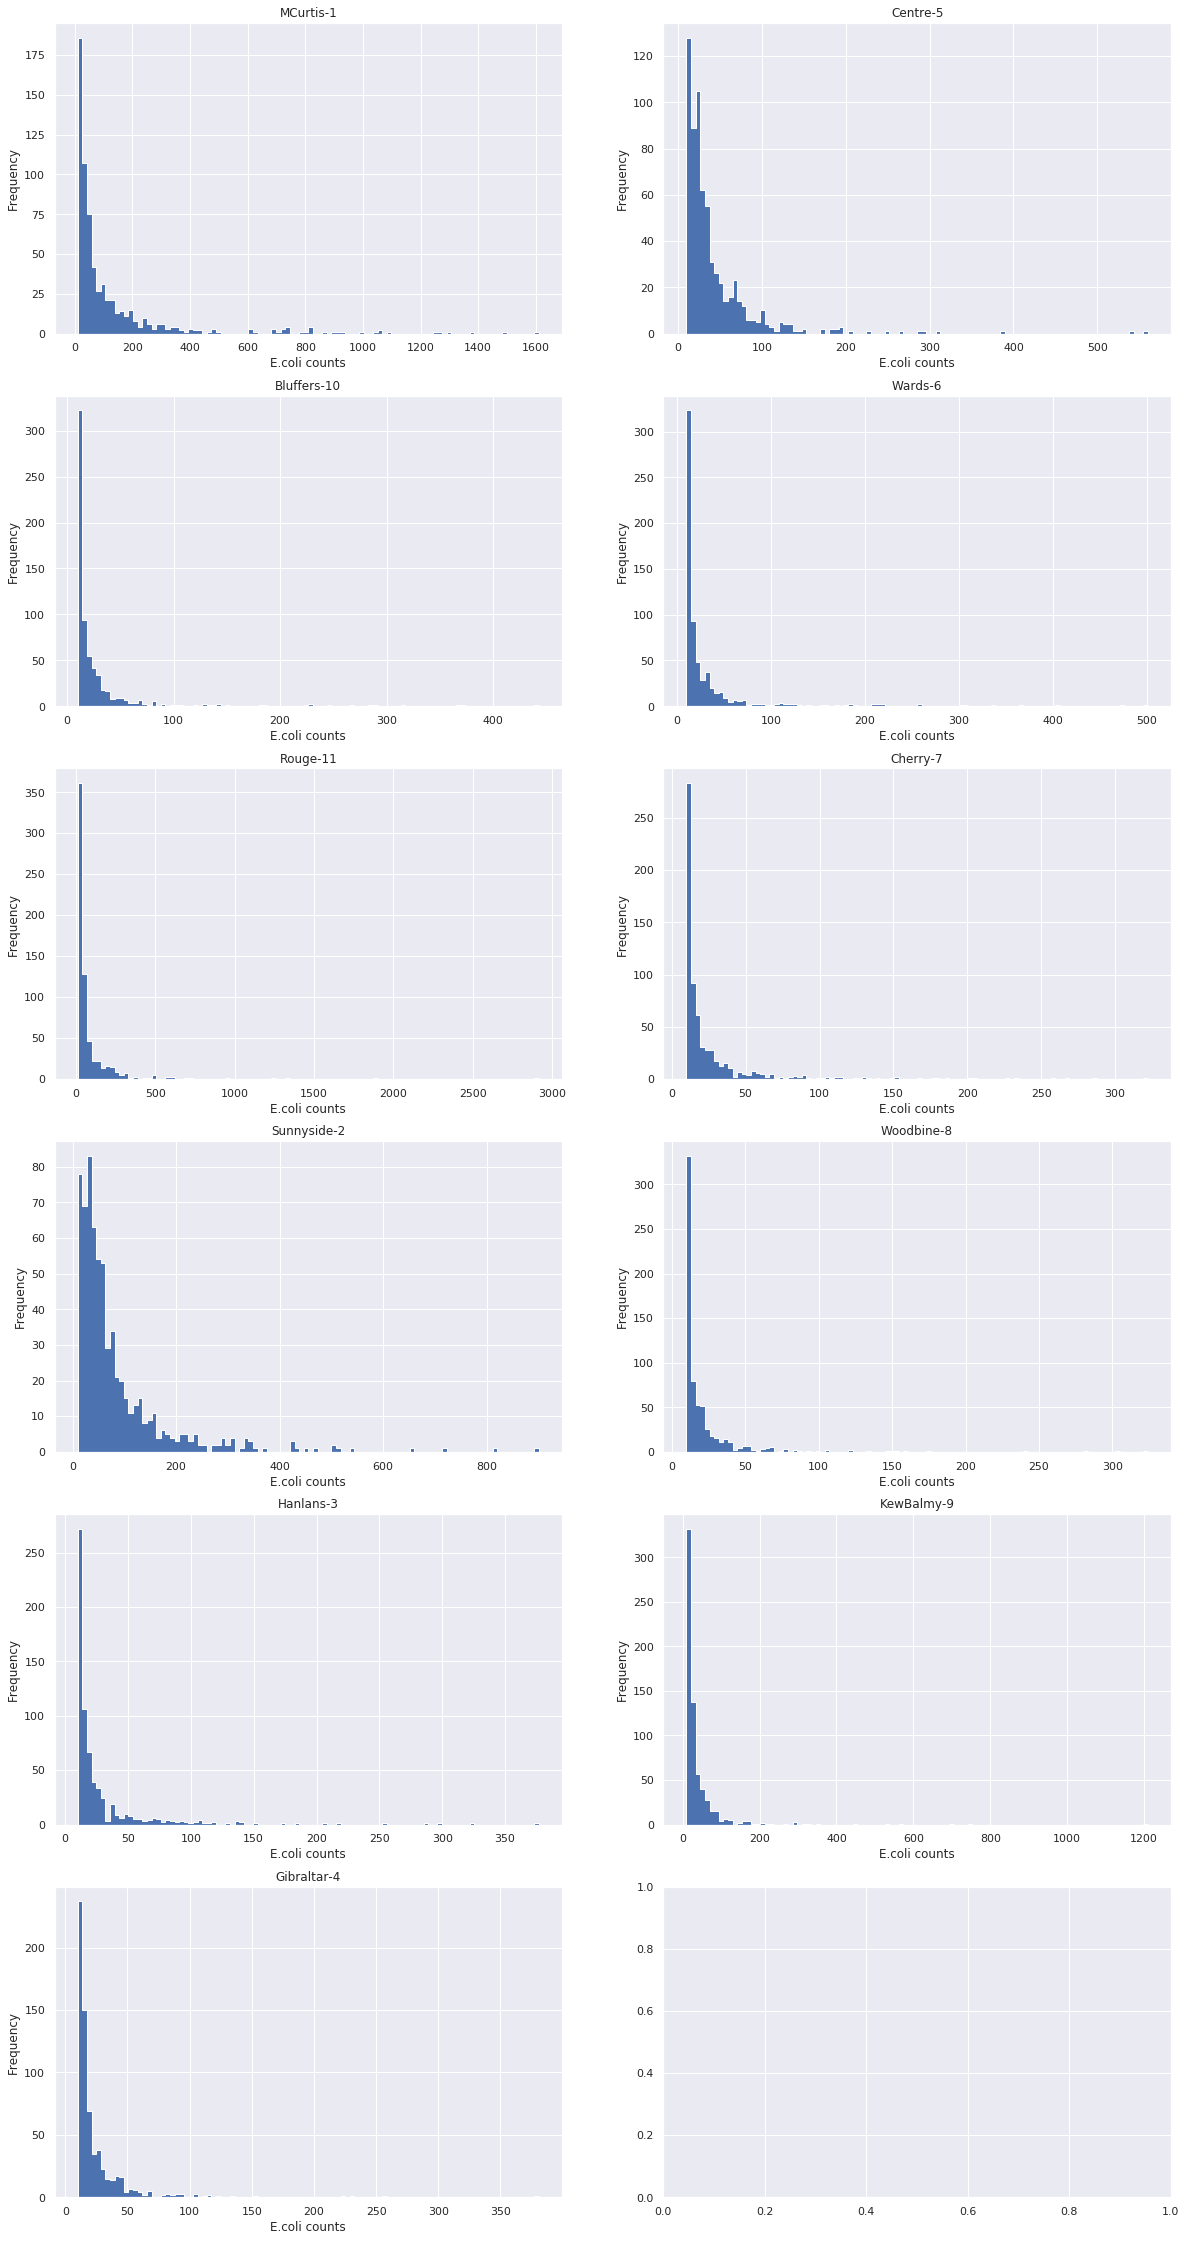

In [79]:
fig, ax = plt.subplots(6, 2, figsize=(20,40))
cols = beach_clean.columns
for i in range(6):
    for j in range(2):
        if j == 1 and i == 5:
            break
        elif j == 0:
            ax[i][j].hist(beach_clean[cols[i]].values, bins=100, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i])
            #set_trace()
        else:
            ax[i][j].hist(beach_clean[cols[i+6]].values, bins=100, histtype='stepfilled')
            ax[i][j].set(xlabel='E.coli counts',ylabel='Frequency',title=cols[i+6])
#plt.show();

In [19]:
#As an example - Time Series for e.Coli counts at Sunnyside beach - this is the raw version of the data
beach2TS = beach_complete['Sunnyside-2'].dropna()
beach2TS.head()

sampleDate
2009-06-01    28.0
2009-06-02    16.0
2009-06-03    10.0
2009-06-04    10.0
2009-06-05    11.0
Name: Sunnyside-2, dtype: float64

In [20]:
#Time Series for e.Coli counts at rest of the beaches
beach1TS = beach_complete['MCurtis-1'].dropna()
beach3TS = beach_complete['Hanlans-3'].dropna()
beach4TS = beach_complete['Gibraltar-4'].dropna()
beach5TS = beach_complete['Centre-5'].dropna()
beach6TS = beach_complete['Wards-6'].dropna()
beach7TS = beach_complete['Cherry-7'].dropna()
beach8TS = beach_complete['Woodbine-8'].dropna()
beach9TS = beach_complete['KewBalmy-9'].dropna()
beach10TS = beach_complete['Bluffers-10'].dropna()
beach11TS = beach_complete['Rouge-11'].dropna()

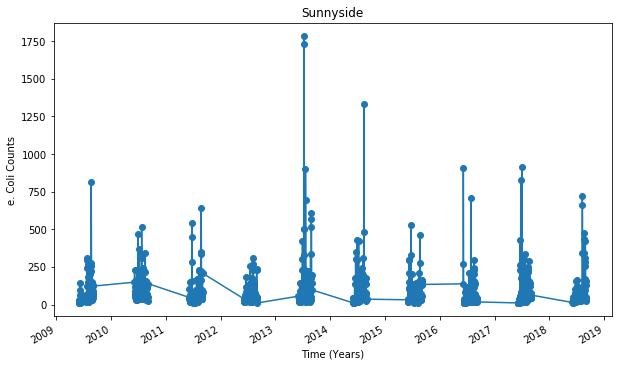

In [21]:
plt.figure(figsize=(10,6))
sunnyside_plot = beach2TS.plot(style='-o', title = 'Sunnyside')
sunnyside_plot.set_ylabel('e. Coli Counts')
sunnyside_plot.set_xlabel('Time (Years)')
plt.show();

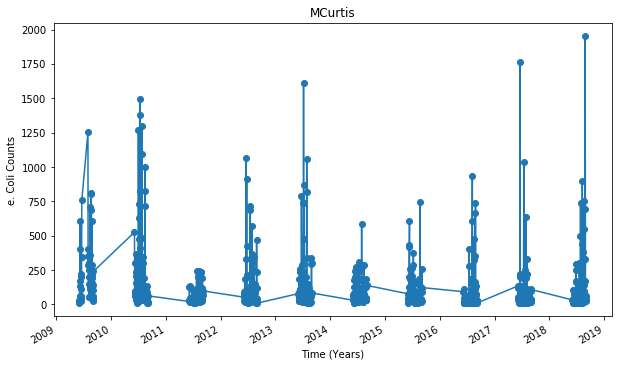

In [22]:
plt.figure(figsize=(10,6))
mcurtis_plot = beach1TS.plot(style='-o', title = 'MCurtis')
mcurtis_plot.set_ylabel('e. Coli Counts')
mcurtis_plot.set_xlabel('Time (Years)')
plt.show();

# Step 2: Remove unwanted seasonality & check stationarity

In [23]:
#Create a list of series and titles to assist in graphing the e.Coli counts for each beach
list_series = [beach_complete[col].dropna().astype(int) for col in beach_complete]
list_titles = [x for x in beach_complete.columns]

In [24]:
#Remove any NaN values from each series
#for series in list_series:
#    series.dropna().astype(int)

In [25]:
list_series

[sampleDate
 2009-06-01      27
 2009-06-02      10
 2009-06-03      22
 2009-06-04      26
 2009-06-05      35
 2009-06-06     133
 2009-06-07     604
 2009-06-08     405
 2009-06-10     170
 2009-06-11      62
 2009-06-12      26
 2009-06-13     114
 2009-06-14     219
 2009-06-15     199
 2009-06-16      47
 2009-06-17      62
 2009-06-19     343
 2009-06-20     758
 2009-07-31    1252
 2009-08-01     356
 2009-08-02     284
 2009-08-03     407
 2009-08-04     149
 2009-08-05     305
 2009-08-06     356
 2009-08-07      53
 2009-08-08      53
 2009-08-09     252
 2009-08-10     199
 2009-08-11     113
               ... 
 2018-08-01      23
 2018-08-02      51
 2018-08-03      48
 2018-08-04      15
 2018-08-05      11
 2018-08-06      12
 2018-08-07     115
 2018-08-08     895
 2018-08-09     440
 2018-08-10     385
 2018-08-11     313
 2018-08-12      40
 2018-08-13      28
 2018-08-14      57
 2018-08-15      34
 2018-08-16      17
 2018-08-17     100
 2018-08-18     752
 2018-08

In [26]:
#Check the list titles
list_titles

['MCurtis-1',
 'Bluffers-10',
 'Rouge-11',
 'Sunnyside-2',
 'Hanlans-3',
 'Gibraltar-4',
 'Centre-5',
 'Wards-6',
 'Cherry-7',
 'Woodbine-8',
 'KewBalmy-9']

In [27]:
#beach2TS.index = pd.to_datetime(beach2TS.index)
#beach2TS.index

In [28]:
#beach1TS.index = pd.to_datetime(beach1TS.index)
#beach3TS.index = pd.to_datetime(beach3TS.index)
#beach4TS.index = pd.to_datetime(beach4TS.index)
#beach5TS.index = pd.to_datetime(beach5TS.index)
#beach6TS.index = pd.to_datetime(beach6TS.index)
#beach7TS.index = pd.to_datetime(beach7TS.index)
#beach8TS.index = pd.to_datetime(beach8TS.index)
#beach9TS.index = pd.to_datetime(beach9TS.index)
#beach10TS.index = pd.to_datetime(beach10TS.index)
#beach11TS.index = pd.to_datetime(beach11TS.index)

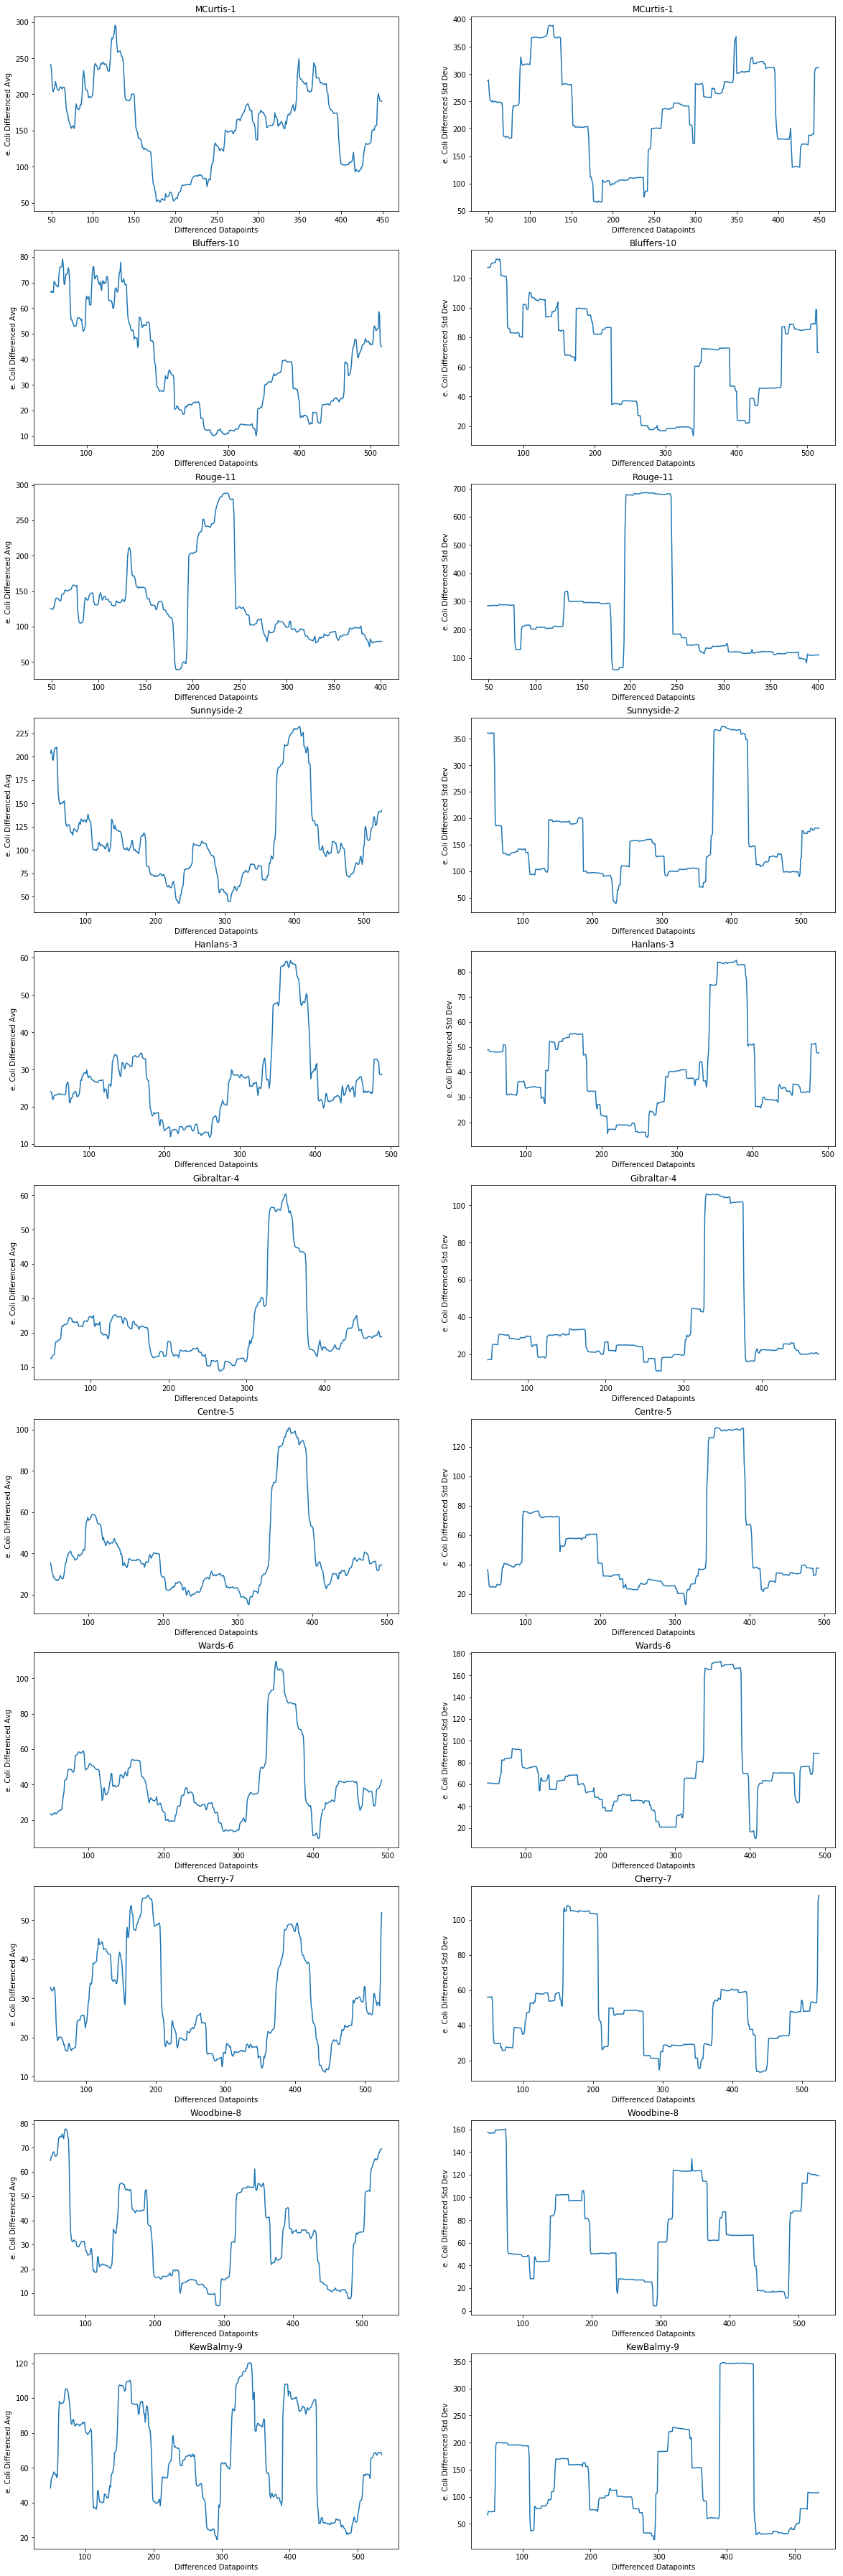

In [29]:
#Differencing of the data to remove the unwanted seasonality and check for stationarity
diff_series = []
days_in_year = 365
for series in list_series:
    diff = []
    for i in range(days_in_year, series.size):
        value = np.abs(series[i] - series[i - days_in_year])
        diff.append(value)
    diff_series.append(pd.Series(diff))
diff_series[0]

#Plot all diffs
f, ax = plt.subplots(11, 2, figsize=(20,50))
row_size = 2
col_size = 11
for i in range(col_size):
    for j in range(row_size):
        if j == 0:
            ax[i][j].plot(diff_series[i].rolling(window=50).mean())
            ax[i][j].set(xlabel='Differenced Datapoints', ylabel='e. Coli Differenced Avg', 
                         title = list_titles[i])
        else:
            ax[i][j].plot(diff_series[i].rolling(window=50).std())
            ax[i][j].set(xlabel='Differenced Datapoints', ylabel='e. Coli Differenced Std Dev', 
                         title = list_titles[i])
plt.subplots_adjust(bottom=-0.1)

/home/rkumar/anaconda3/envs/DS1ENV/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rkumar/anaconda3/envs/DS1ENV/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


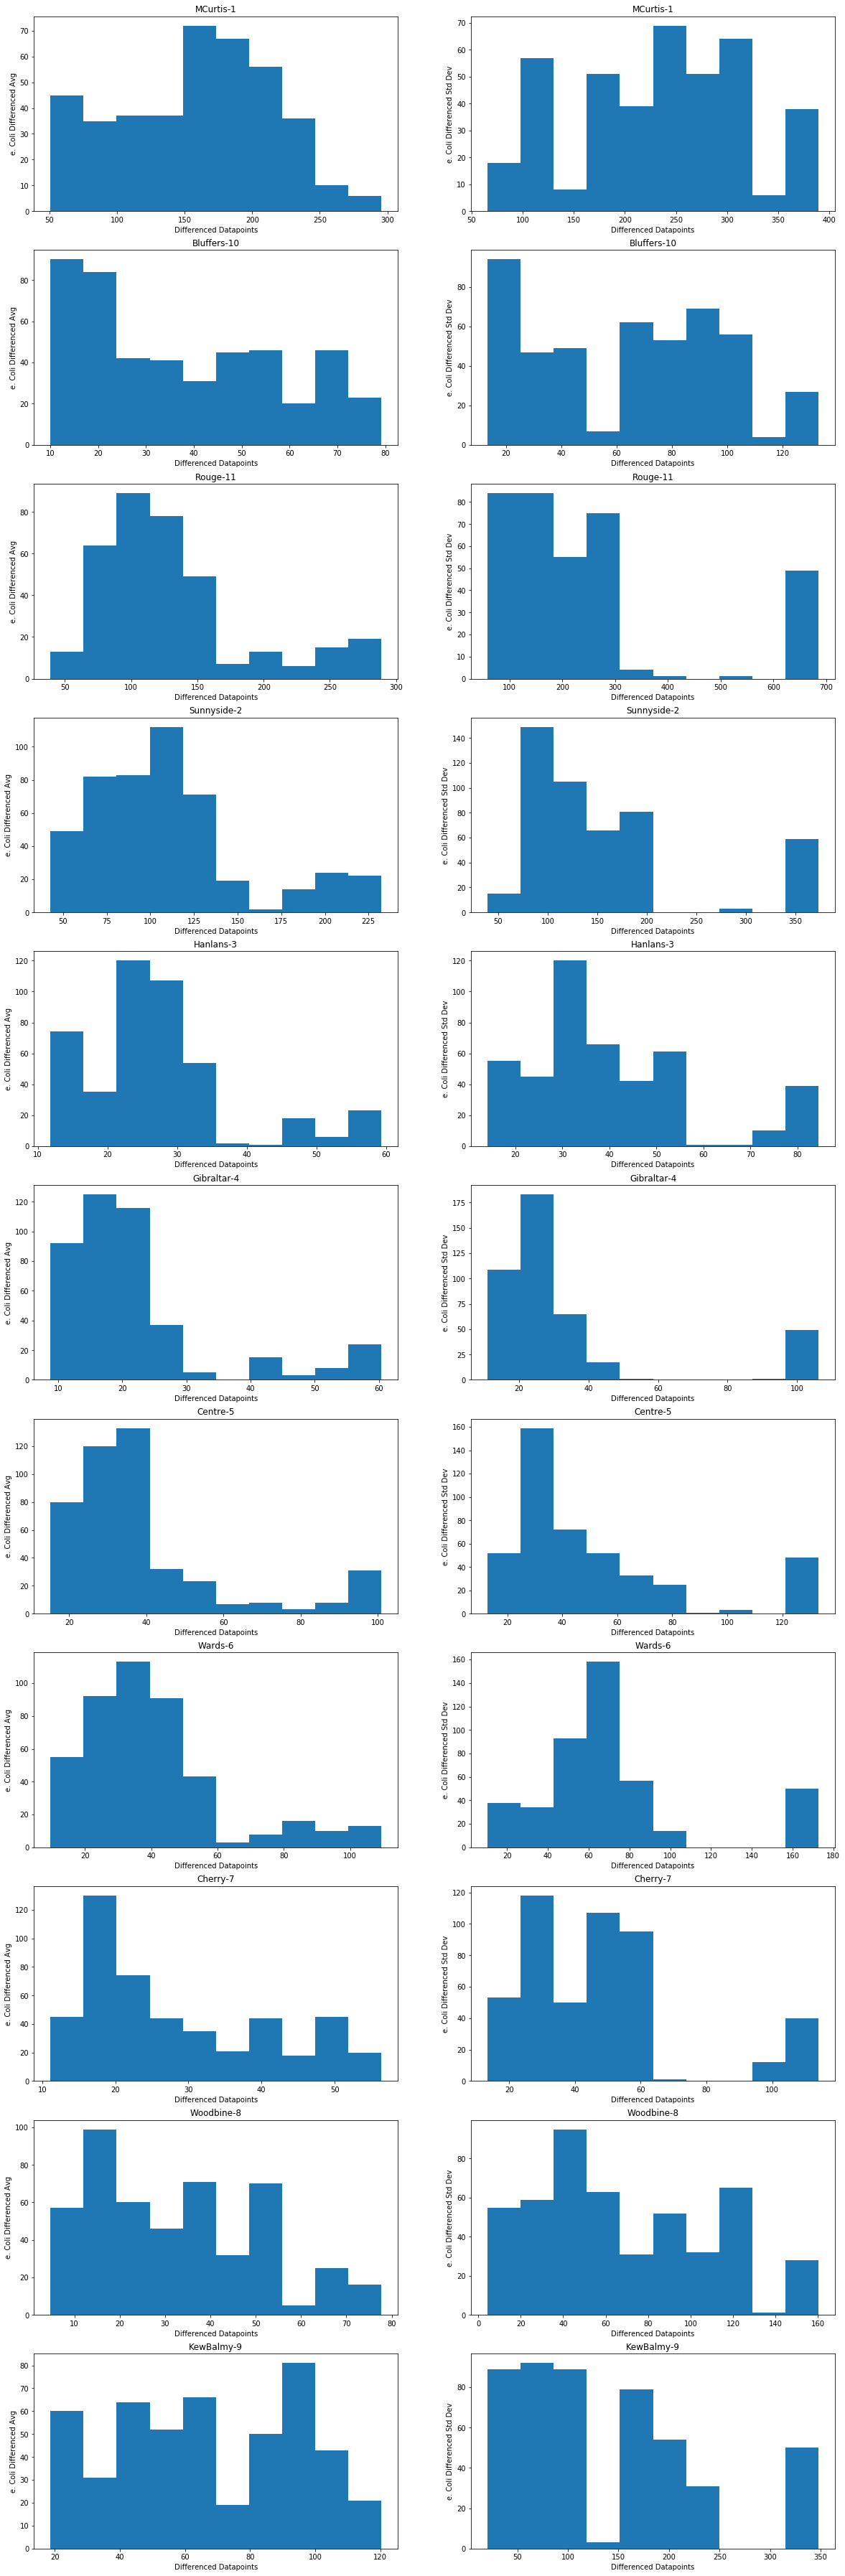

In [30]:
#Check what the distribution of the data looks like with histograms
diff_series = []
days_in_year = 365
for series in list_series:
    diff = []
    for i in range(days_in_year, series.size):
        value = np.abs(series[i] - series[i - days_in_year])
        diff.append(value)
    diff_series.append(pd.Series(diff))
diff_series[0]

#Plot all diffs
f, ax = plt.subplots(11, 2, figsize=(20,50))
row_size = 2
col_size = 11
for i in range(col_size):
    for j in range(row_size):
        if j == 0:
            ax[i][j].hist(diff_series[i].rolling(window=50).mean(), bins=10, histtype='stepfilled')
            ax[i][j].set(xlabel='Differenced Datapoints', ylabel='e. Coli Differenced Avg', 
                         title = list_titles[i])
        else:
            ax[i][j].hist(diff_series[i].rolling(window=50).std(), bins=10, histtype='stepfilled')
            ax[i][j].set(xlabel='Differenced Datapoints', ylabel='e. Coli Differenced Std Dev', 
                         title = list_titles[i])
plt.subplots_adjust(bottom=-0.1)

The above differenced graph looks quite stationary considering it does not have an upward or downward inclination.

In [31]:
zipped = zip(list_series, list_titles)

In [32]:
list_tuples = list(zipped)

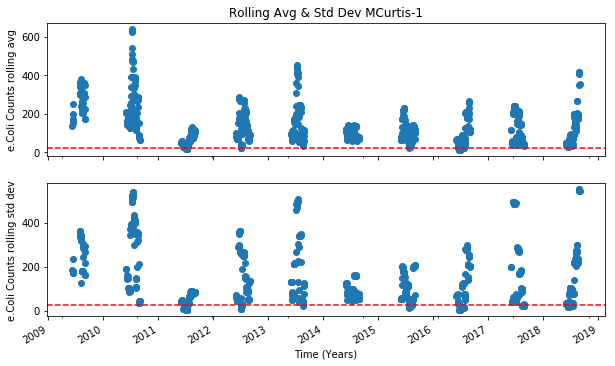

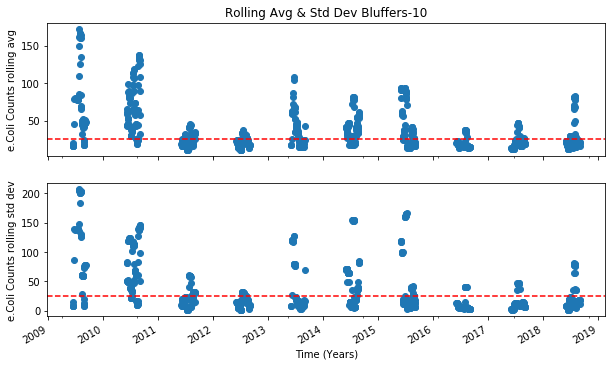

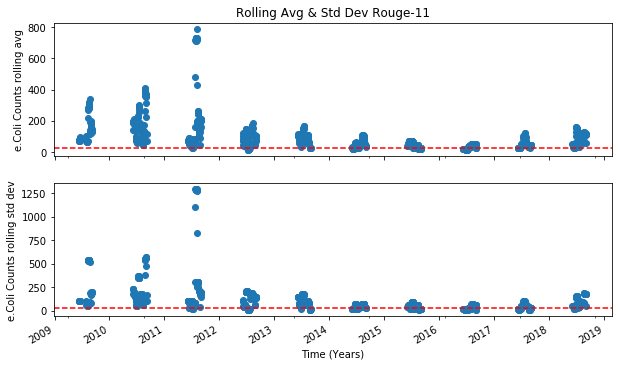

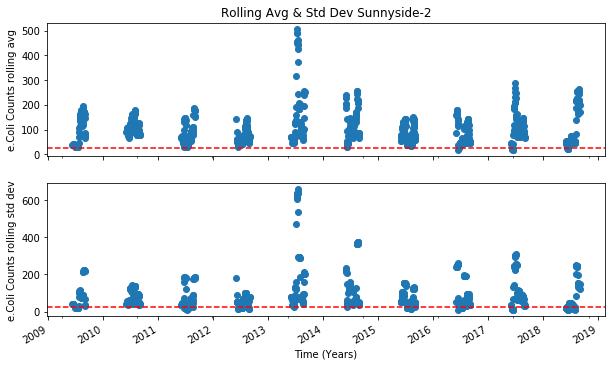

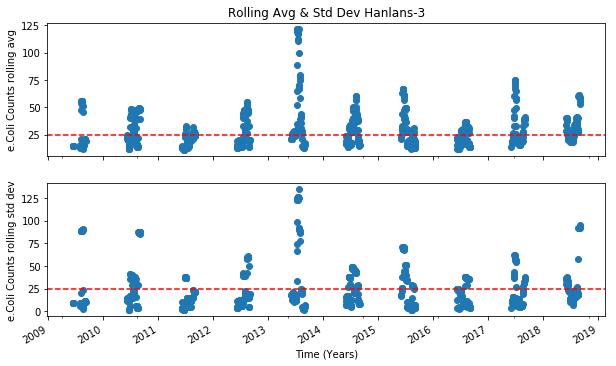

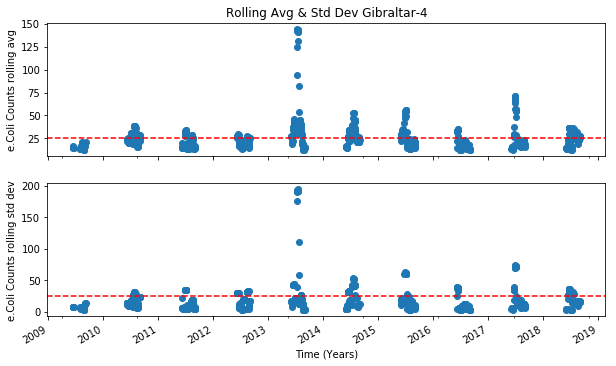

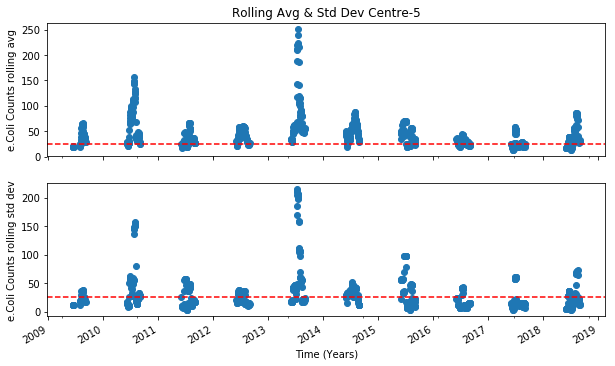

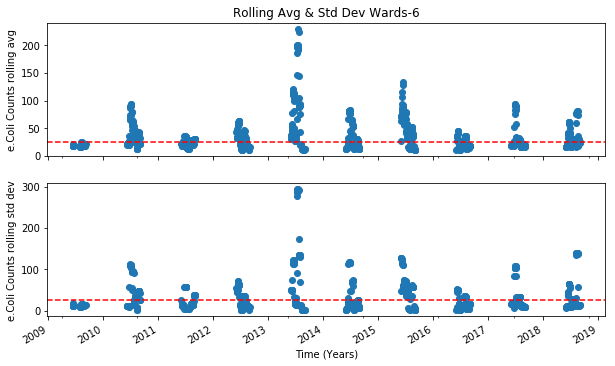

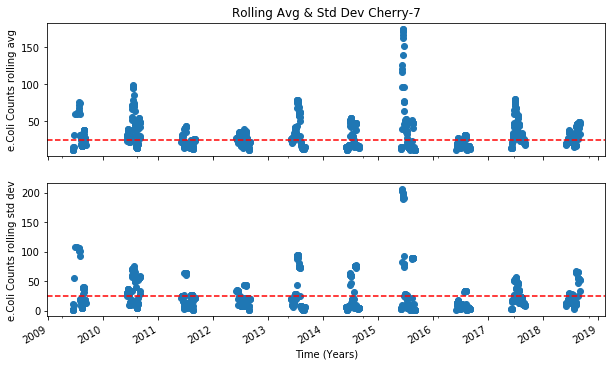

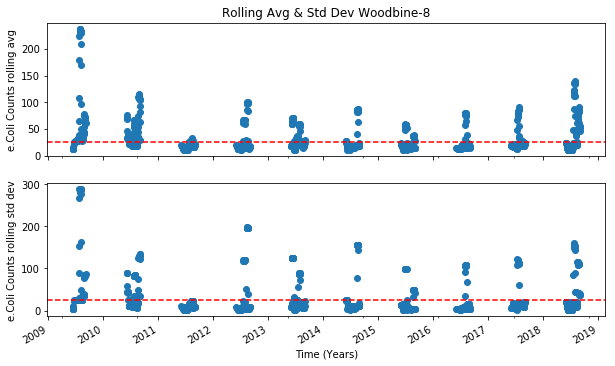

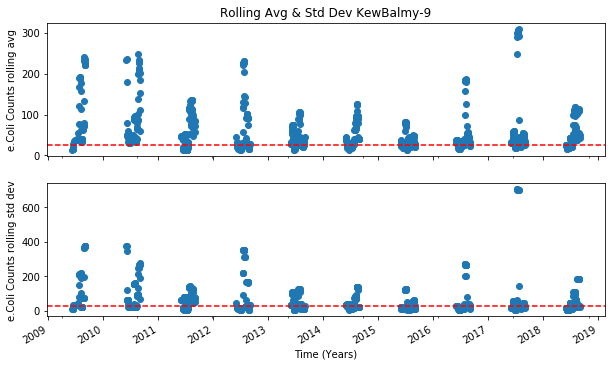

In [33]:
#Just a repeat of above differenced data - this code is unnecessary
def plot_stationary(list_tuples):
    for tup in list_tuples:
        #print(tup[1])
        series = tup[0]
        title = tup[1]
        str_title = 'Rolling Avg & Std Dev ' + title
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,6))
        series.rolling(window=12).mean().plot(style='o', ax=ax1)
        series.rolling(window=12).std().plot(style='o',ax=ax2)
        ax1.set(xlabel='Time (Years)', ylabel='e.Coli Counts rolling avg', title = str_title)
        ax2.set(xlabel='Time (Years)', ylabel='e.Coli Counts rolling std dev')
        ax1.axhline(y=25, color='r', linestyle='--')
        ax2.axhline(y=25, color='r', linestyle='--')
        plt.show();

plot_stationary(list_tuples)

 The above stionarity checks for both rolling average and rolling std dev show that the e.Coli count data are stationary over the past 10 years at Sunnyside beach. There are no downward/uppward trends in the data.

# Step 4: ACF and PACF plots

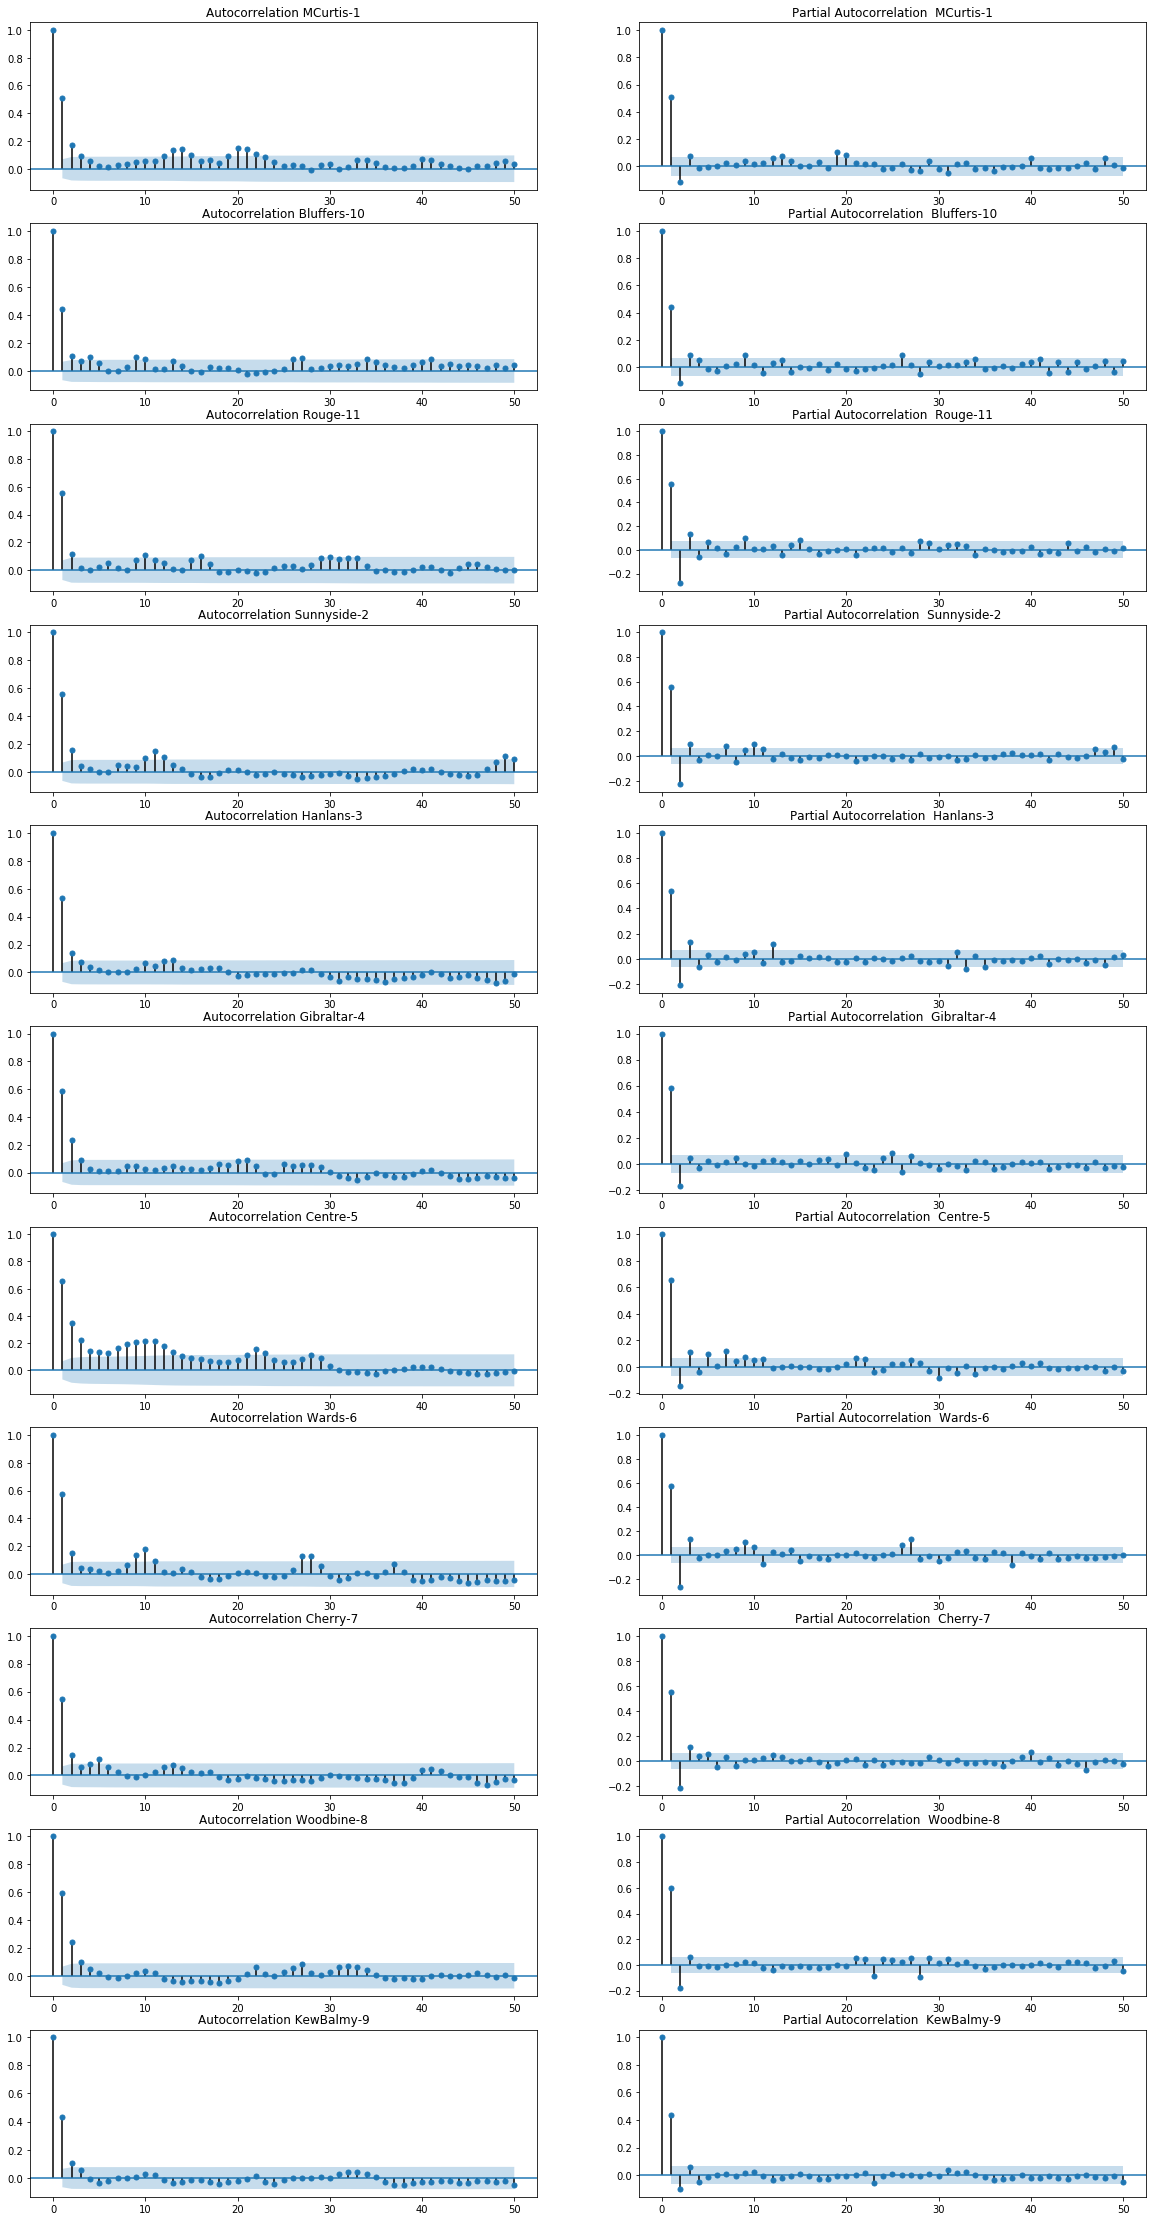

In [34]:
def plot_acf_pacf(list_tuples):
    fig, ax = plt.subplots(11, 2, figsize=(20,40))
    for i in range(len(list_tuples)):
        for j in range(len(list_tuples[i])-1):
            str_title_acf = "Autocorrelation " + list_tuples[i][1]
            str_title_pacf = "Partial Autocorrelation  " + list_tuples[i][1]
            plot_acf(list_tuples[i][0], lags=50, title=str_title_acf, ax=ax[i][j])
            plot_pacf(list_tuples[i][0], lags=50, title=str_title_pacf, ax=ax[i][j+1])
    
    plt.show();

plot_acf_pacf(list_tuples)

For all 11 beaches, it seems that with a lag=6 there will be very little partial correlation. So we assume lag=6 for both our AR and MA parameters for now.

# Step 5: Train and Test ARIMA model 

In [35]:
#Get 70% train, 30% test datasets for all beaches data
def get_train_test(tuples):
    train_data, test_data = [], []
    train_titles, test_titles = [], []
    #err_check_ctr = 0
    for tup in tuples:
        training_size = int(tup[0].values.size * 0.7)
        training_set = tup[0][:training_size]
        testing_set = tup[0][training_size:tup[0].values.size]
        training_title = 'Training ' + tup[1]
        testing_title = 'Testing ' + tup[1]
        
        #check if there are any null values in train/test datasets
        #err_check_ctr = 1
        #if err_check_ctr == 1:
        #    assert training_set.notnull().values.any(), 'Null Values Found in Training Dataset!'
        #    assert testing_set.notnull().values.any(), 'Null Values Found in Testing Dataset!'
        #    err_check_ctr = 0
        
        train_data.append(training_set)
        test_data.append(testing_set)
        train_titles.append(training_title)
        test_titles.append(testing_title)
    
    return (pd.DataFrame(train_data).transpose().dropna(), pd.DataFrame(test_data).transpose().dropna())

train_test_tuple = get_train_test(list_tuples)    

In [36]:
train_test_tuple[0].head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2009-06-01,27.0,12.0,39.0,28.0,11.0,18.0,24.0,63.0,51.0,10.0,10.0
2009-06-02,10.0,14.0,52.0,16.0,10.0,18.0,22.0,18.0,19.0,10.0,10.0
2009-06-03,22.0,11.0,14.0,10.0,10.0,11.0,14.0,10.0,10.0,10.0,10.0
2009-06-04,26.0,10.0,11.0,10.0,10.0,11.0,11.0,10.0,10.0,10.0,10.0
2009-06-05,35.0,10.0,31.0,11.0,10.0,10.0,10.0,12.0,10.0,10.0,10.0
2009-06-06,133.0,13.0,29.0,18.0,12.0,10.0,12.0,16.0,10.0,12.0,10.0
2009-06-07,604.0,16.0,20.0,97.0,37.0,28.0,41.0,47.0,10.0,12.0,11.0
2009-06-08,405.0,17.0,99.0,142.0,31.0,33.0,43.0,39.0,10.0,10.0,12.0
2009-06-10,170.0,25.0,155.0,26.0,11.0,18.0,21.0,11.0,12.0,18.0,31.0


In [37]:
train_test_tuple[1].head(10)

,MCurtis-1,Bluffers-10,Rouge-11,Sunnyside-2,Hanlans-3,Gibraltar-4,Centre-5,Wards-6,Cherry-7,Woodbine-8,KewBalmy-9
sampleDate,,,,,,,,,,,
2016-06-30,10.0,14.0,10.0,16.0,11.0,11.0,30.0,10.0,14.0,10.0,14.0
2016-07-01,10.0,18.0,17.0,34.0,15.0,13.0,47.0,20.0,15.0,16.0,38.0
2016-07-02,13.0,18.0,17.0,56.0,16.0,16.0,31.0,32.0,34.0,17.0,33.0
2016-07-03,36.0,10.0,21.0,17.0,11.0,14.0,25.0,23.0,23.0,13.0,11.0
2016-07-04,41.0,12.0,50.0,15.0,11.0,13.0,32.0,16.0,12.0,20.0,15.0
2016-07-05,52.0,17.0,31.0,42.0,15.0,20.0,18.0,11.0,14.0,18.0,17.0
2016-07-06,46.0,14.0,16.0,73.0,29.0,22.0,14.0,14.0,14.0,18.0,12.0
2016-07-07,27.0,20.0,15.0,79.0,58.0,16.0,14.0,16.0,13.0,33.0,16.0
2016-07-08,32.0,27.0,18.0,52.0,37.0,17.0,28.0,13.0,13.0,27.0,26.0


In [38]:
#Instantiate the ARIMA model with train data and create a model just to predict
#the N+1 entry using the trained data
def single_model_arima(train_data, train_titles):
    arr = np.zeros((1, 4))
    arima_model_fits = []
    train_titles_arr = np.array([train_titles])
    for beach in train_data:
        amodel = ARIMA(endog=beach.values, order=(6,1,1)) #initialize the ARIMA model with training data
        amodel_fit = amodel.fit(disp=1,maxiter=500) #fit the ARIMA model to the training data
        p, err, conf = amodel_fit.forecast() #ARIMA model forecast
        
        params = np.append(p,[err[0],conf[0][0],conf[0][1]]) #Get the parameters (p, err, conf) into an array
        arima_model_fits.append(amodel_fit) #Get all the fit models so we can get their summaries later on
        #set_trace()
        arr = np.append(arr,[params], axis=0) #Append params array to main array
    
    arr = np.delete(arr, (0), axis=0)
    arr = np.concatenate((arr, train_titles_arr.T), axis=1)
    
    return pd.DataFrame(arr[:,:4], index=arr[:,4].T, columns=['N+1 Prediction','Std Error','CI Low','CI High'])

train_data = [train_test_tuple[0][col] for col in train_test_tuple[0]]
train_titles = [col for col in train_test_tuple[0]]
train_results = single_model_arima(train_data, train_titles)

In [39]:
#Change all values in training results to float64
train_results = train_results.applymap(float)

In [40]:
#Check percentage differences between predictions and actual test values
abs_diff = np.abs(train_results['N+1 Prediction'] - train_test_tuple[1].iloc[0])
abs_diff

MCurtis-1      31.536524
Bluffers-10     1.358810
Rouge-11       19.276080
Sunnyside-2    57.746498
Hanlans-3      10.693020
Gibraltar-4    12.046408
Centre-5        0.349633
Wards-6        18.923724
Cherry-7        6.645011
Woodbine-8      3.221307
KewBalmy-9      5.649034
dtype: float64

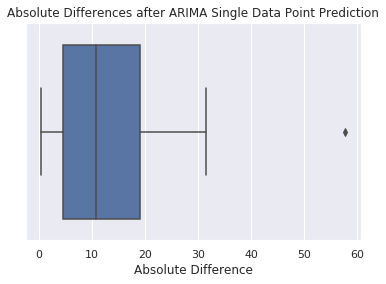

In [41]:
sns.set(style='darkgrid')
ax = sns.boxplot(x=abs_diff)
ax.set(xlabel='Absolute Difference', title='Absolute Differences after ARIMA Single Data Point Prediction');

The above percentage errors varies from -34% (lowest) to 328% (highest). These values represents the difference between predicted vs actual e.Coli count. For smaller differences, it can be said that the model fits well. However for larger differences, more predictions are needed based on the arima model.

In following section, more predictions are done for all beaches except for MCurtis, Centre, Woodbine, and Kewbalmy as the percentage error is small for these four. 

In [42]:
#Create more predictions using arima model TODO

#def multi_model_arima(train_test_tuple, train_titles):
#    arr = np.zeros((1, train_test_tuple[1]['MCurtis-1'].size))
    #print(arr)
#    train_titles_arr = np.array([train_titles])
#    for col in train_test_tuple[0]:
#        pred=[]
#        hist=list(train_test_tuple[0][col].values)

#        for i in range(train_test_tuple[1][col].size):
            #step 0: Initialize the ARIMA model
#            arima_model = ARIMA(endog=hist, order=(1,1,1))
            #step 1: Fit the arima model
            #set_trace()
#            arima_fit = arima_model.fit(disp=1, maxiter=100)
            #step 2: Forecast with the arima model
#            p = arima_fit.forecast()[0][0]
            #step 3: Add predicted value (p) to prediction list
            #set_trace()
#            pred.append(p)
            #step 4: Then add the current value to the history
#            hist.append(train_test_tuple[1][col].values[i])
            #step 5: Append the predicted results to the return array
        
        #set_trace()
#        pred_array = np.array(pred)
#        arr = np.append(arr, [pred], axis=0)
    
#    arr = np.delete(arr, (0), axis=0)
#    print(arr)
        #arr = np.concatenate((arr, pred), axis=0)
        #print(arr)
        #break
               
#train_data = [train_test_tuple[0][col] for col in train_test_tuple[0]]
#train_titles = [col for col in train_test_tuple[0]]
#predictions = [pred1, pred10, pred11, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9]
#print(train_test_tuple[1]['MCurtis-1'].size)
#multi_model_arima(train_test_tuple, train_titles)

In [43]:
pred_mcurtis=[]
hist_mcurtis=list(train_test_tuple[0]['MCurtis-1'].values)

for i in range(train_test_tuple[1]['MCurtis-1'].size):
    arima_model_mcurtis = ARIMA(endog=hist_mcurtis, order=(6,1,1))
    arima_fit_mcurtis = arima_model_mcurtis.fit()
    p_mcurtis = arima_fit_mcurtis.forecast()[0][0]
    pred_mcurtis.append(p_mcurtis)
    hist_mcurtis.append(train_test_tuple[1]['MCurtis-1'].values[i]) #pass 611

KeyboardInterrupt: 

In [ ]:
pred_sunnyside=[]
hist_sunnyside=list(train_test_tuple[0]['Sunnyside-2'].values)

for i in range(train_test_tuple[1]['Sunnyside-2'].size):
    arima_model_sunnyside = ARIMA(endog=hist_sunnyside, order=(6,1,1))
    arima_fit_sunnyside = arima_model_sunnyside.fit()
    p_sunnyside = arima_fit_sunnyside.forecast()[0][0]
    pred_sunnyside.append(p_sunnyside)
    hist_sunnyside.append(train_test_tuple[1]['Sunnyside-2'].values[i]) #pass 611

In [ ]:
pred_hanlans=[]
hist_hanlans=list(train_test_tuple[0]['Hanlans-3'].values)

for i in range(train_test_tuple[1]['Hanlans-3'].size):
    arima_model_hanlans = ARIMA(endog=hist_hanlans, order=(6,1,1))
    arima_fit_hanlans = arima_model_hanlans.fit()
    p_hanlans = arima_fit_hanlans.forecast()[0][0]
    pred_hanlans.append(p_hanlans)
    hist_hanlans.append(train_test_tuple[1]['Hanlans-3'].values[i]) #pass 611

In [ ]:
pred_gibraltar=[]
hist_gibraltar=list(train_test_tuple[0]['Gibraltar-4'].values)

for i in range(train_test_tuple[1]['Gibraltar-4'].size):
    arima_model_gibraltar = ARIMA(endog=hist_gibraltar, order=(6,1,1))
    arima_fit_gibraltar = arima_model_gibraltar.fit()
    p_gibraltar = arima_fit_gibraltar.forecast()[0][0]
    pred_gibraltar.append(p_gibraltar)
    hist_gibraltar.append(train_test_tuple[1]['Gibraltar-4'].values[i]) #pass 611

In [ ]:
pred_centre=[]
hist_centre=list(train_test_tuple[0]['Centre-5'].values)

for i in range(train_test_tuple[1]['Centre-5'].size):
    arima_model_centre = ARIMA(endog=hist_centre, order=(6,1,1))
    arima_fit_centre = arima_model_centre.fit()
    p_centre = arima_fit_centre.forecast()[0][0]
    pred_centre.append(p_centre)
    hist_centre.append(train_test_tuple[1]['Centre-5'].values[i]) #pass 611

In [ ]:
pred_wards=[]
hist_wards=list(train_test_tuple[0]['Wards-6'].values)

for i in range(train_test_tuple[1]['Wards-6'].size):
    arima_model_wards = ARIMA(endog=hist_wards, order=(6,1,1))
    arima_fit_wards = arima_model_wards.fit()
    p_wards = arima_fit_wards.forecast()[0][0]
    pred_wards.append(p_wards)
    hist_wards.append(train_test_tuple[1]['Wards-6'].values[i]) #pass 611

In [ ]:
pred_cherry=[]
hist_cherry=list(train_test_tuple[0]['Cherry-7'].values)

for i in range(train_test_tuple[1]['Cherry-7'].size):
    arima_model_cherry = ARIMA(endog=hist_cherry, order=(6,1,1))
    arima_fit_cherry = arima_model_cherry.fit()
    p_cherry = arima_fit_cherry.forecast()[0][0]
    pred_cherry.append(p_cherry)
    hist_cherry.append(train_test_tuple[1]['Cherry-7'].values[i]) #pass 611

In [ ]:
pred_woodbine=[]
hist_woodbine=list(train_test_tuple[0]['Woodbine-8'].values)

for i in range(train_test_tuple[1]['Woodbine-8'].size):
    arima_model_woodbine = ARIMA(endog=hist_woodbine, order=(6,1,1))
    arima_fit_woodbine = arima_model_woodbine.fit()
    p_woodbine = arima_fit_woodbine.forecast()[0][0]
    pred_woodbine.append(p_woodbine)
    hist_woodbine.append(train_test_tuple[1]['Woodbine-8'].values[i]) #pass 611

In [ ]:
pred_kewbalmy=[]
hist_kewbalmy=list(train_test_tuple[0]['KewBalmy-9'].values)

for i in range(train_test_tuple[1]['KewBalmy-9'].size):
    arima_model_kewbalmy = ARIMA(endog=hist_kewbalmy, order=(6,1,1))
    arima_fit_kewbalmy = arima_model_kewbalmy.fit()
    p_kewbalmy = arima_fit_kewbalmy.forecast()[0][0]
    pred_kewbalmy.append(p_kewbalmy)
    hist_kewbalmy.append(train_test_tuple[1]['KewBalmy-9'].values[i]) #pass 611

In [ ]:
pred_bluffers=[]
hist_bluffers=list(train_test_tuple[0]['Bluffers-10'].values)

for i in range(train_test_tuple[1]['Bluffers-10'].size):
    arima_model_bluffers = ARIMA(endog=hist_bluffers, order=(6,1,1))
    arima_fit_bluffers = arima_model_bluffers.fit()
    p_bluffers = arima_fit_bluffers.forecast()[0][0]
    pred_bluffers.append(p_bluffers)
    hist_bluffers.append(train_test_tuple[1]['Bluffers-10'].values[i]) #pass 611

In [ ]:
pred_rouge=[]
hist_rouge=list(train_test_tuple[0]['Rouge-11'].values)

for i in range(train_test_tuple[1]['Rouge-11'].size):
    arima_model_rouge = ARIMA(endog=hist_rouge, order=(6,1,1))
    arima_fit_rouge = arima_model_rouge.fit()
    p_rouge = arima_fit_rouge.forecast()[0][0]
    pred_rouge.append(p_rouge)
    hist_rouge.append(train_test_tuple[1]['Rouge-11'].values[i]) #pass 611

Graph the predictions and the actual values of the test data below.

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_mcurtis, 'r-')
plt.plot(train_test_tuple[1]['MCurtis-1'].values, '--')
plt.title('Marie Curtis Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_sunnyside, 'r-')
plt.plot(train_test_tuple[1]['Sunnyside-2'].values, '--')
plt.title('Sunnyside Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_hanlans, 'r-')
plt.plot(train_test_tuple[1]['Hanlans-3'].values, '--')
plt.title('Hanlans Point e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_gibraltar, 'r-')
plt.plot(train_test_tuple[1]['Gibraltar-4'].values, '--')
plt.title('Gibraltar Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_centre, 'r-')
plt.plot(train_test_tuple[1]['Centre-5'].values, '--')
plt.title('Centre Island Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_wards, 'r-')
plt.plot(train_test_tuple[1]['Wards-6'].values, '--')
plt.title('Wards Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_cherry, 'r-')
plt.plot(train_test_tuple[1]['Cherry-7'].values, '--')
plt.title('Cherry Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_woodbine, 'r-')
plt.plot(train_test_tuple[1]['Woodbine-8'].values, '--')
plt.title('Woodbine Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_kewbalmy, 'r-')
plt.plot(train_test_tuple[1]['KewBalmy-9'].values, '--')
plt.title('KewBalmy Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_bluffers, 'r-')
plt.plot(train_test_tuple[1]['Bluffers-10'].values, '--')
plt.title('Bluffers Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(pred_rouge, 'r-')
plt.plot(train_test_tuple[1]['Rouge-11'].values, '--')
plt.title('Rouge Beach e.Coli counts (2016-2018) ARIMA prediction versus actual values')
plt.show();

Eyeballing the graphs above, the ARIMA model seems to have done a good job at predicting the last 30% of the Sunnyside beach e.Coli count (2016-2018) based on the first 70% (2009-2016). This needs to be verified by comparing the rmse values with all the other beaches.

In [ ]:
mean_square_err_mcurtis = mean_squared_error(pred_mcurtis, train_test_tuple[1]['MCurtis-1'].values)
print("Mean square error MCurtis:", mean_square_err_mcurtis)

mean_square_err_sunnyside = mean_squared_error(pred_sunnyside, train_test_tuple[1]['Sunnyside-2'].values)
print("Mean square error Sunnyside:", mean_square_err_sunnyside)

mean_square_err_hanlans = mean_squared_error(pred_hanlans, train_test_tuple[1]['Hanlans-3'].values)
print("Mean square error Hanlans:", mean_square_err_hanlans)

mean_square_err_gibraltar = mean_squared_error(pred_gibraltar, train_test_tuple[1]['Gibraltar-4'].values)
print("Mean square error Gibraltar:", mean_square_err_gibraltar)

mean_square_err_centre = mean_squared_error(pred_centre, train_test_tuple[1]['Centre-5'].values)
print("Mean square error Centre:", mean_square_err_centre)

mean_square_err_wards = mean_squared_error(pred_wards, train_test_tuple[1]['Wards-6'].values)
print("Mean square error Wards:", mean_square_err_wards)

mean_square_err_cherry = mean_squared_error(pred_cherry, train_test_tuple[1]['Cherry-7'].values)
print("Mean square error Cherry:", mean_square_err_cherry)

mean_square_err_woodbine = mean_squared_error(pred_woodbine, train_test_tuple[1]['Woodbine-8'].values)
print("Mean square error Woodbine:", mean_square_err_woodbine)

mean_square_err_kewbalmy = mean_squared_error(pred_kewbalmy, train_test_tuple[1]['KewBalmy-9'].values)
print("Mean square error Kewbalmy:", mean_square_err_kewbalmy)

mean_square_err_bluffers = mean_squared_error(pred_bluffers, train_test_tuple[1]['Bluffers-10'].values)
print("Mean square error Bluffers:", mean_square_err_bluffers)

mean_square_err_rouge = mean_squared_error(pred_rouge, train_test_tuple[1]['Rouge-11'].values)
print("Mean square error Rouge:", mean_square_err_rouge)

In [ ]:
rmse_mcurtis = np.sqrt(mean_square_err_mcurtis)
rmse_sunnyside = np.sqrt(mean_square_err_sunnyside)
rmse_hanlans = np.sqrt(mean_square_err_hanlans)
rmse_gibraltar = np.sqrt(mean_square_err_gibraltar)
rmse_centre = np.sqrt(mean_square_err_centre)
rmse_wards = np.sqrt(mean_square_err_wards)
rmse_cherry = np.sqrt(mean_square_err_cherry)
rmse_woodbine = np.sqrt(mean_square_err_woodbine)
rmse_kewbalmy = np.sqrt(mean_square_err_kewbalmy)
rmse_bluffers = np.sqrt(mean_square_err_bluffers)
rmse_rouge = np.sqrt(mean_square_err_rouge)

In [ ]:
print("RMSE MCurtis:", rmse_mcurtis)
print("RMSE Sunnyside:", rmse_sunnyside)
print("RMSE Hanlans:", rmse_hanlans)
print("RMSE Gibraltar:", rmse_gibraltar)
print("RMSE Centre:", rmse_centre)
print("RMSE Wards:", rmse_wards)
print("RMSE Cherry:", rmse_cherry)
print("RMSE Woodbine:", rmse_woodbine)
print("RMSE Kewbalmy:", rmse_kewbalmy)
print("RMSE Bluffers:", rmse_bluffers)
print("RMSE Rouge:", rmse_rouge)

In [ ]:
rmses = np.array([rmse_mcurtis, rmse_sunnyside, rmse_hanlans, rmse_gibraltar, 
         rmse_centre, rmse_wards, rmse_cherry, rmse_woodbine, rmse_kewbalmy, rmse_bluffers, rmse_rouge])

rmse_df = pd.DataFrame(rmses, columns=['RMSE'])
rmse_df

sns.set(style='darkgrid')
ax = sns.boxplot(x=rmse_df['RMSE'])
ax.set(xlabel='RMSE', title='RMSE values after ARIMA Expanded Prediction');

# Step 6: ARIMA Model Test Results 

In [ ]:
arima_fit_mcurtis.summary()

In [ ]:
arima_fit_sunnyside.summary()

In [ ]:
arima_fit_hanlans.summary()

In [ ]:
arima_fit_gibraltar.summary()

In [ ]:
arima_fit_centre.summary()

In [ ]:
arima_fit_wards.summary()

In [ ]:
arima_fit_cherry.summary()

In [ ]:
arima_fit_woodbine.summary()

In [ ]:
arima_fit_kewbalmy.summary()

In [ ]:
arima_fit_bluffers.summary()

In [ ]:
arima_fit_rouge.summary()

The RMSE values closer to 0 indicates better fit. 

From above RMSE values, it is clear that ARIMA predictions were better for following beaches: Gibraltar, Centre, and Cherry. 

For Sunnyside, MCurtis and Kewbalmy, the ARIMA predictions are not reliable and hence other models should be used for better predictions. 

ARIMA did not perform so well for beaches Wards, Woodbine, and Rouge as well.

For all beaches, the ARIMA model with parameters (p,d,q) = (6,1,1) did not predict well on sudden spikes in e.Coli counts. This could possibly be because of the sudden changes that these spikes bring compared to the base values seen at the bottom of the above graphs. This will be explored in future with more fine-tuned ARIMA models. 

In [ ]:
#test